/opt/conda/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


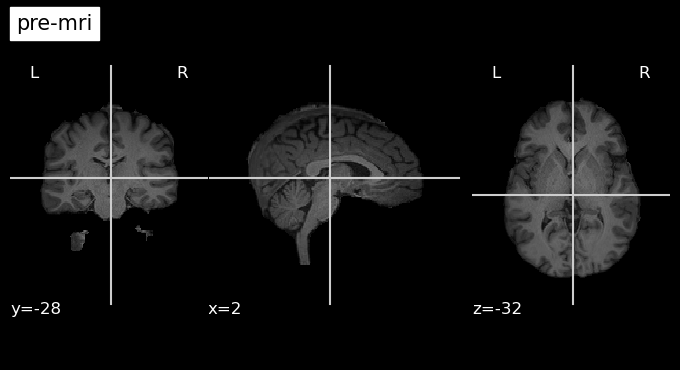

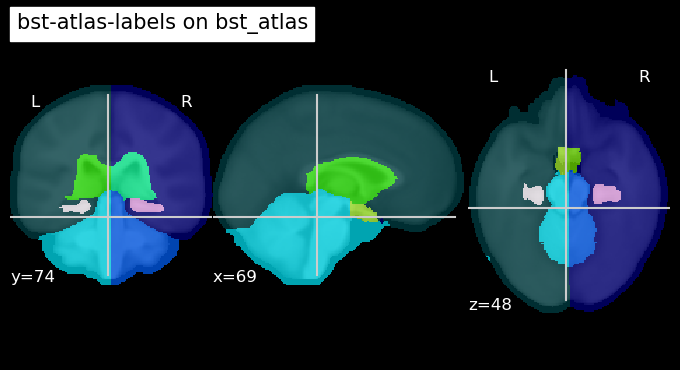

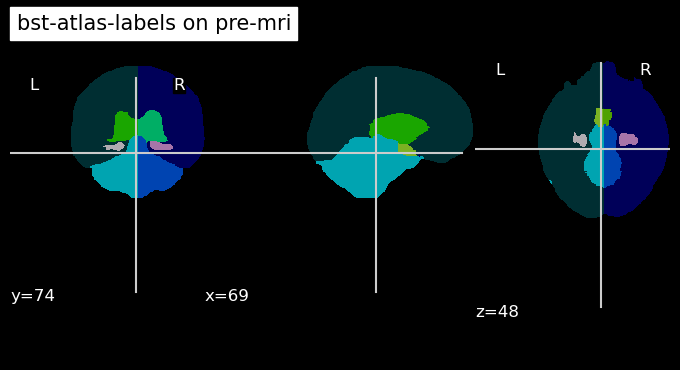

In [1]:
from aligner import Aligner, center_and_resample_images
from monai.transforms import LoadImage, EnsureChannelFirst
import nibabel as nib
from nilearn.plotting import plot_anat, plot_roi
import matplotlib.pyplot as plt
import matplotlib
from warp_utils import apply_warp


pre_mri = '/deneb_disk/auto_resection/data_8_4_2023/sub-M1998N33/sMRI/sub-M1998N33-M1998N33_MRI.bse.nii.gz'

bst_atlas = '/deneb_disk/auto_resection/bst_atlases/icbm_bst.nii.gz'
bst_atlas_labels = '/deneb_disk/auto_resection/bst_atlases/icbm_bst.label.nii.gz'

cent_bst_atlas = 'cent_T1_brain_t1.nii.gz'
cent_bst_atlas_labels = 'cent_T1_brain_t1.label.nii.gz'

plot_anat(pre_mri, title='pre-mri')
plot_roi(bst_atlas_labels, bg_img=bst_atlas, title='bst-atlas-labels on bst_atlas')
plot_roi(bst_atlas_labels, bg_img=pre_mri, title='bst-atlas-labels on pre-mri')

In [ ]:
center_and_resample_images(pre_mri, bst_atlas, centered_atlas=cent_bst_atlas,
                           atlas_labels=bst_atlas_labels, centered_atlas_labels=cent_bst_atlas_labels)

plot_roi(cent_bst_atlas_labels, bg_img=pre_mri, alpha=0.25, title='centered bst-atlas')

In [ ]:

affine_reg = Aligner()

ddf = "ddf_temp.nii.gz"
out_img = "out_img.nii.gz"
out_labels = "out_labels.nii.gz"

affine_reg.affine_reg(
    fixed_file=pre_mri,
    moving_file=cent_bst_atlas,
    output_file=out_img,
    ddf_file=ddf,
    loss="cc",
    nn_input_size=64,
    lr=1e-6,
    max_epochs=3000,
    device="cuda",
)



In [ ]:

moving = LoadImage(image_only=True)(cent_bst_atlas_labels)
moving = EnsureChannelFirst()(moving)

target = LoadImage(image_only=True)(pre_mri)
target = EnsureChannelFirst()(target)


image_movedo = apply_warp(affine_reg.ddf[None,], moving[None,], target[None,],interp_mode='nearest')

nib.save(
    nib.Nifti1Image(image_movedo[0, 0].detach(
    ).cpu().numpy(), affine_reg.target.affine),
    out_labels,
)

plot_roi(out_labels, bg_img=pre_mri, title='out-labels over pre-mri')
